In [8]:
# Post Processing Notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

from pathlib import Path
import numpy as np
import pandas as pd
import random, getopt, os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from Lamp.AttrDict.AttrDict import *
from Lamp.Model.Dataloader import *
from Lamp.Model.BaseModel import *
from Lamp.Model.Resnet import *
from Lamp.preprocessing.preprocessing import Custom, Erosion, Mask, Labelize, Closing, Dilation, Rescale_Intenstiy, define_regions

In [9]:
def set_seed(seed):
    """ Set the random seed """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def load_config(cfg_path):
    """  """
    if os.path.splitext(cfg_path)[-1] == '.json':
        return AttrDict.from_json_path(cfg_path)
    elif os.path.splitext(cfg_path)[-1] in ['.yaml', '.yml']:
        return AttrDict.from_yaml_path(cfg_path)
    else:
        raise ValueError(f"Unsupported config file format. Only '.json', '.yaml' and '.yml' files are supported.")

def resnet(layers=[3, 4, 6, 3],channels=3, num_classes=1000):
    model = ResNet(BasicBlock,layers,channels=channels,num_classes=num_classes)
    return model

class Classifier(BaseModelSingle):
    def __init__(self, net: nn.Module, opt: Optimizer = None, sched: _LRScheduler = None, 
        logger: Logger = None, print_progress: bool = True, device: str = 'cuda:0', **kwargs):
        super().__init__(net, opt=opt, sched=sched, logger=logger, print_progress=print_progress, device=device, **kwargs)

    def forward_loss(self, data: Tuple[Tensor]) -> Tensor:
        """  """
        pass

    def predict(self, loader):
        """  """
        labels = []
        self.net.eval()
        with torch.no_grad():
            for b, data in enumerate(loader):
                input, label = data
                input = input.to(self.device)
                label = label.to(self.device).long()

                output = self.net(input)
                pred = torch.argmax(output, dim=1)

                labels += list(zip(pred.cpu().data.tolist(), label.cpu().data.tolist()))

            pred, label = zip(*labels)
        #acc = accuracy_score(np.array(label), np.array(pred))

        return pred, label

In [10]:
# Load config_file
ifile = '../Models/config/MAR_RESNET34_PADDED_256_ALL.yaml'

inputs = load_config(ifile)

# Handle config_file inputs
k = int(inputs.KFold)
seed = int(inputs.Seed)
n_samples = int(inputs.NSamples)
layers = inputs.Model.Layers # [3, 4, 6, 3] for ResNet34 and [2, 2, 2, 2] for ResNet18
classes = inputs.Model.OutClasses
channels = inputs.Model.Channels
batch_size = inputs.BatchSize

# Handle file paths
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"
path_load_data = f"{root_path}/{inputs.LoadPath}" # Path for the .csv file

# Seed
set_seed(seed)

# Pytorch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

# Read dataset
dataframe = pd.read_csv(path_load_data,index_col=0)

# Train Test Split
train_dataframe, _ = train_test_split(dataframe, test_size=(1 - inputs.TrainTestSplit),stratify=dataframe['Label'], random_state=inputs.Seed)

# Reset Index
train_dataframe = train_dataframe.reset_index(drop=True)

# Samples
train_dataframe = train_dataframe.groupby('Label').sample(n_samples,replace=True,random_state=inputs.Seed).reset_index(drop=True)

X = train_dataframe.iloc[:,:-1]
y = train_dataframe.iloc[:,-1]

# Stratified KFold
kf = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)

# Transforms (other than MinMaxNorm and ToTensor)
dict_transform = {
    "Padding":Padding,
    "VerticalFlip":tf.RandomVerticalFlip,
    "HorizontalFlip":tf.RandomHorizontalFlip,
    "Rotation":tf.RandomRotation,
    "CenterCrop":tf.CenterCrop,
    "Resize":tf.Resize,
    }

transforms_test = Transforms(
    [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
    )

accuracy_scores = []
for i_, (train_index, test_index) in enumerate(kf.split(X,y)):

    model_name = f"model_{i_}.pt"
    save_model_path = f"{path_model}/{model_name}"

    print('Model :',save_model_path)

    testDataset = Dataset(
        train_dataframe.loc[test_index,:].reset_index(drop=True),
        transforms=transforms_test.get_transforms()
        )

    test_dataloader = torch.utils.data.DataLoader(
        testDataset, 
        shuffle=True
        )

    net = resnet(layers=layers,channels=channels,num_classes=classes)

    classifier = Classifier(
                net=net, 
                device=device
                )

    classifier.load(save_model_path)

    pred, label = classifier.predict(test_dataloader)

    accuracy_scores.append(accuracy_score(np.array(label), np.array(pred)))

print(accuracy_scores)


cuda:0
NVIDIA GeForce 940MX
Model : c:\Users\nilso\Documents\EPFL\MA4\PDS Turberg\Rock_Cuttings_Characterisation\Cuttings_Characterisation/Models/outputs//MAR_RESNET34_PADDED_256_ALL/model_0.pt
Model : c:\Users\nilso\Documents\EPFL\MA4\PDS Turberg\Rock_Cuttings_Characterisation\Cuttings_Characterisation/Models/outputs//MAR_RESNET34_PADDED_256_ALL/model_1.pt
Model : c:\Users\nilso\Documents\EPFL\MA4\PDS Turberg\Rock_Cuttings_Characterisation\Cuttings_Characterisation/Models/outputs//MAR_RESNET34_PADDED_256_ALL/model_2.pt
Model : c:\Users\nilso\Documents\EPFL\MA4\PDS Turberg\Rock_Cuttings_Characterisation\Cuttings_Characterisation/Models/outputs//MAR_RESNET34_PADDED_256_ALL/model_3.pt
Model : c:\Users\nilso\Documents\EPFL\MA4\PDS Turberg\Rock_Cuttings_Characterisation\Cuttings_Characterisation/Models/outputs//MAR_RESNET34_PADDED_256_ALL/model_4.pt
[0.971, 0.981, 0.986, 0.983, 0.984]


In [11]:
dict_acc_scores = {inputs.ModelName : accuracy_scores}

In [36]:
#with open(f'{ifile}','w') as file :
#    print(yaml.dump(inputs, file))

In [37]:
# Load, detect and classify cuttings from an image

In [12]:
root_load = 'E:/FileHistory/nilso/LAPTOP-154DU0LI/Data/C/Users/nilso/Documents/EPFL/MA4/PDS Turberg/'
folder_to_load = 'Cuttings_data/BL3-4-DL/'
train_tiffs = os.listdir(os.path.dirname(root_load + folder_to_load))
tiff = train_tiffs[990]

file_path = root_load + folder_to_load + tiff


In [13]:
image_raw = Image_Raw(file_path,'unchanged')

# First
Custom().apply(image = image_raw, thres = Otsu().return_threshold(image_raw))

# Second 
selem = disk(2)
Erosion(selem=selem).apply(image_raw)

# Third
Mask().apply(image_raw)
Labelize().apply(image_raw,threshold=5000)

# Fourth
selem = disk(5)
Closing(selem=selem).apply_regions(image_raw)

# Fifth
selem = disk(2)
Erosion(selem=selem).apply(image_raw, 3)

# Sixth
Mask().apply(image_raw)
Labelize().apply(image_raw,threshold=5000)

# Seventh
selem = disk(2)
Dilation(selem=selem).apply(image_raw,4)

# Eigth
Rescale_Intenstiy().apply_regions(image_raw, in_range=(1,99), out_range = (0,1), background=False)

define_regions(image_raw)

C:\Users\nilso\Anaconda3\envs\TORCH\lib\site-packages\skimage\util\dtype.py:525: UserWarning: Downcasting int32 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


In [44]:
# Model prediciton
def load_config(cfg_path):
    """  """
    if os.path.splitext(cfg_path)[-1] == '.json':
        return AttrDict.from_json_path(cfg_path)
    elif os.path.splitext(cfg_path)[-1] in ['.yaml', '.yml']:
        return AttrDict.from_yaml_path(cfg_path)
    else:
        raise ValueError(f"Unsupported config file format. Only '.json', '.yaml' and '.yml' files are supported.")

def resnet(layers=[3, 4, 6, 3],channels=3, num_classes=1000):
    model = ResNet(BasicBlock,layers,channels=channels,num_classes=num_classes)
    return model

class Classifier(BaseModelSingle):
    def __init__(self, net: nn.Module, opt: Optimizer = None, sched: _LRScheduler = None, 
        logger: Logger = None, print_progress: bool = True, device: str = 'cuda:0', **kwargs):
        super().__init__(net, opt=opt, sched=sched, logger=logger, print_progress=print_progress, device=device, **kwargs)

    def forward_loss(self, data: Tuple[Tensor]) -> Tensor:
        """  """
        pass

    def predict(self, loader):
        """  """
        labels = []
        self.net.eval()
        with torch.no_grad():
            for b, data in enumerate(loader):
                input = data
                input = input.to(self.device)

                output = self.net(input)
                pred = torch.argmax(output, dim=1)

                labels.append(pred.cpu().data.tolist())
        return labels

class Dataset(data.Dataset):
    def __init__(self,image_raw,transforms):
        self.image_raw = image_raw
    
        self.transform = transforms
    
    def __len__(self):
        return len(self.image_raw.regions)

    def __getitem__(self,idx):

        im = Image.fromarray(image_raw.regions[idx]['mar']['new'])
        im = self.transform(im)

        return im

# Transforms (other than MinMaxNorm and ToTensor)
dict_transform = {
    "Padding":Padding,
    "VerticalFlip":tf.RandomVerticalFlip,
    "HorizontalFlip":tf.RandomHorizontalFlip,
    "Rotation":tf.RandomRotation,
    "CenterCrop":tf.CenterCrop,
    "Resize":tf.Resize,
    }

ifile = '../Models/config/MAR_RESNET34_PADDED_256_ALL.yaml'

inputs = load_config(ifile)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"

transforms_test = Transforms(
    [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
    )

# Change dataset
testDataset = Dataset(
    image_raw,
    transforms=transforms_test.get_transforms()
    )

test_dataloader = torch.utils.data.DataLoader(
    testDataset, 
    shuffle=False,
    batch_size=1
    )

net = resnet(layers=layers,channels=channels,num_classes=classes)

classifier = Classifier(
                net=net, 
                device=device
                )

classifier.load(save_model_path)

pred = classifier.predict(test_dataloader)

In [50]:
dict_ = {0:'BL',1:'GN',2:'ML',3:'MS',4:'OL'}

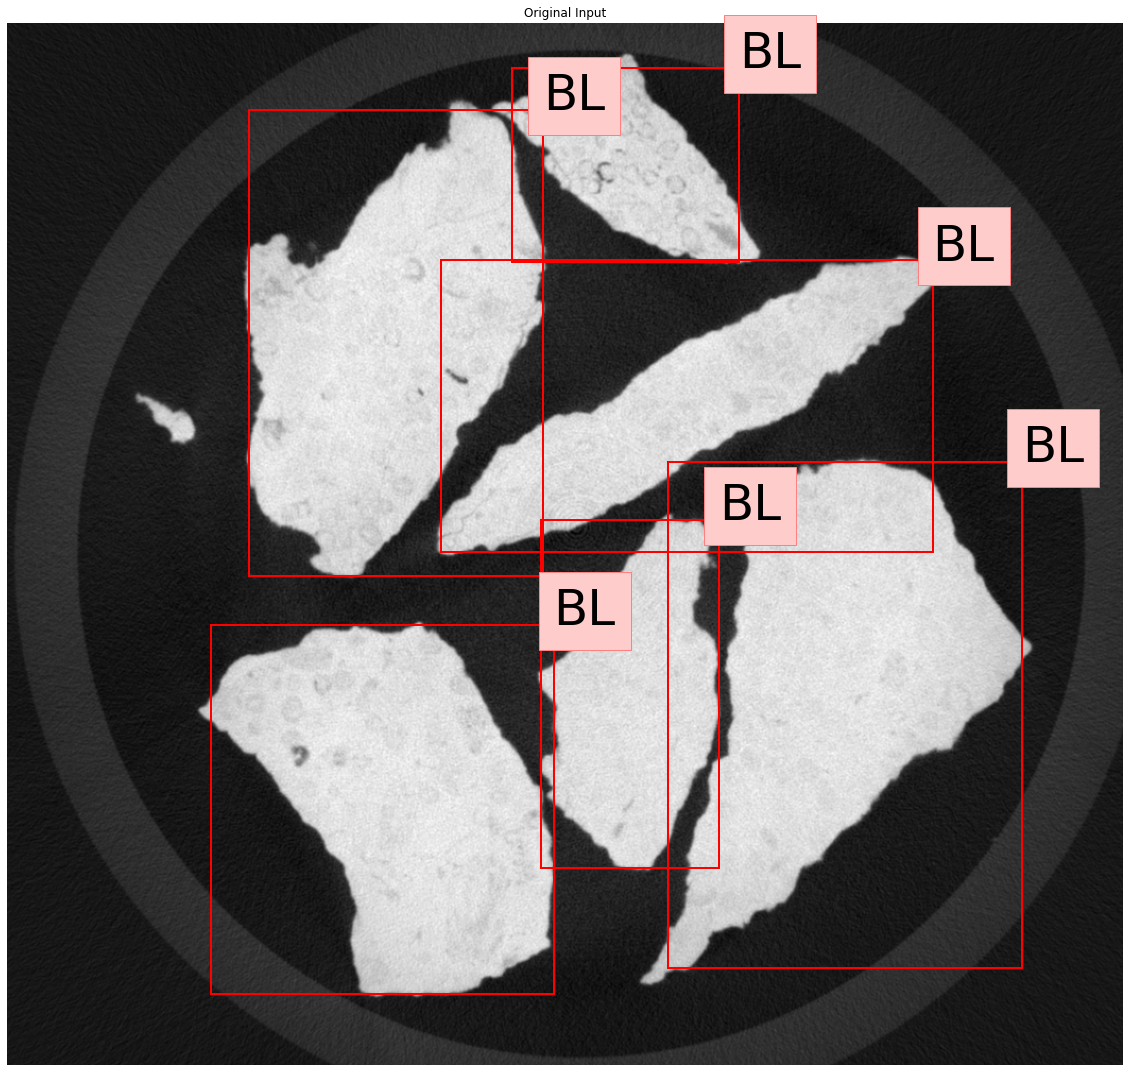

In [60]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(image_raw.img,cmap='gray')
ax.set_title('Original Input')
ax.axis(False)

for i_, region_i in enumerate(image_raw.regions):
    box = region_i['bbox']['box']
    poly = patches.Polygon(box,fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(poly)
    ax.text(
        x=box[3,0],
        y=box[3,1],
        s=dict_[pred[i_][0]],
        size=50,
        bbox=dict(
            boxstyle="square",
            ec=(1., 0.5, 0.5),
            fc=(1., 0.8, 0.8)
            )
        )